# Prepare data for DeepSD models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_io
import numpy as np
import xarray as xr
import intake
import dask
import fsspec
import xbatcher
import matplotlib.pyplot as plt

from cmip6_downscaling.data.cmip import get_gcm, get_gcm_grid_spec
from cmip6_downscaling.data.observations import get_obs

2022-02-01 09:01:07.587696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 09:01:07.587747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## GCM grid to use

DeepSD operates on a stacked super resolution model with 2x upscaling factor. This blocks of code examines the grid spacings in each GCM models and how they can be interpolated as a preprocessing step to match with the model that will be trained. 

Models trained on observation data will have the following resolutions:

1) 2   degree -> 1    degree  
2) 1   degree -> 0.5  degree  
3) 0.5 degree -> 0.25 degree  

GCM data will first be interpolated to either 2 degree and 1 degree grids, then upscaled with either models 1-3 stacked or models 2-3 stacked. 

In [3]:
col_url = "https://cmip6downscaling.blob.core.windows.net/cmip6/pangeo-cmip6.json"
activity_ids = "CMIP"
experiment_ids = "historical"
member_ids = "r1i1p1f1"
table_ids = "day"
grid_labels = "gn"
variable_ids = ["tasmax"]

stores = (
    intake.open_esm_datastore(col_url)
    .search(
        activity_id=activity_ids,
        experiment_id=experiment_ids,
        member_id=member_ids,
        # source_id=source_ids,
        table_id=table_ids,
        grid_label=grid_labels,
        variable_id=variable_ids,
    )
)

all_cmip_models = stores.df.source_id.values

In [4]:
initial_resolutions = {}

for gcm_name in all_cmip_models:
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        grid_spec = get_gcm_grid_spec(gcm_name=gcm_name).split('_')
        lat_spacing = int(grid_spec[2]) / 10.
        lon_spacing = int(grid_spec[3]) / 10.
        
        starting_lat = min(round(lat_spacing), 2)
        starting_lon = min(round(lon_spacing), 2)
        starting_spacing = min(starting_lat, starting_lon)
        print(gcm_name.ljust(20), lat_spacing, lon_spacing, 'interpolating to', starting_spacing, 'original gcm_grid_spec', grid_spec)
        initial_resolutions[gcm_name] = float(starting_spacing)

GISS-E2-1-G          2.0 2.5 interpolating to 2 original gcm_grid_spec ['90x144', 'gridsize', '20', '25', 'llcorner', '-89', '1']
BCC-CSM2-MR          1.1 1.1 interpolating to 1 original gcm_grid_spec ['160x320', 'gridsize', '11', '11', 'llcorner', '-89', '0']
AWI-CM-1-1-MR        0.9 0.9 interpolating to 1 original gcm_grid_spec ['192x384', 'gridsize', '9', '9', 'llcorner', '-89', '0']
BCC-ESM1             2.8 2.8 interpolating to 2 original gcm_grid_spec ['64x128', 'gridsize', '28', '28', 'llcorner', '-87', '0']
SAM0-UNICON          0.9 1.2 interpolating to 1 original gcm_grid_spec ['192x288', 'gridsize', '9', '12', 'llcorner', '-90', '0']
CanESM5              2.8 2.8 interpolating to 2 original gcm_grid_spec ['64x128', 'gridsize', '28', '28', 'llcorner', '-87', '0']
MRI-ESM2-0           1.1 1.1 interpolating to 1 original gcm_grid_spec ['160x320', 'gridsize', '11', '11', 'llcorner', '-89', '0']
MPI-ESM-1-2-HAM      1.8 1.9 interpolating to 2 original gcm_grid_spec ['96x192', 'gridsi

In [5]:
# this initial resolution mapping is saved to the `deepsd.py` file and later imported/used in inference

initial_resolutions

{'GISS-E2-1-G': 2.0,
 'BCC-CSM2-MR': 1.0,
 'AWI-CM-1-1-MR': 1.0,
 'BCC-ESM1': 2.0,
 'SAM0-UNICON': 1.0,
 'CanESM5': 2.0,
 'MRI-ESM2-0': 1.0,
 'MPI-ESM-1-2-HAM': 2.0,
 'MPI-ESM1-2-HR': 1.0,
 'MPI-ESM1-2-LR': 2.0,
 'NESM3': 2.0,
 'NorESM2-LM': 2.0,
 'FGOALS-g3': 2.0,
 'MIROC6': 1.0,
 'ACCESS-CM2': 1.0,
 'NorESM2-MM': 1.0,
 'ACCESS-ESM1-5': 1.0,
 'AWI-ESM-1-1-LR': 2.0,
 'TaiESM1': 1.0,
 'NorCPM1': 2.0,
 'CMCC-ESM2': 1.0}

## Coarsen observation 

Coarsen observation from 0.25 degree to 0.5, 1, and 2 degree grids and save. 

There is an initial step that bilinearly interpolates from the observation grid (which has shape 721x1440, including lat of both 90 and -90) to a 0.25 degree grid (shape 720 x 1440, with the center of each grid cell being the lat/lon values). Then, this dataset is coarsened using the conservative method to 0.5, 1.0, and 2.0 degree grids. Data is directly upscaled from 0.25 degrees to 0.5, 1, and 2 degrees instead of iteratively. Finally, the coarsened data is bilinearly interpolated back to a 2x resolution to be used as the input features to the deepsd model. Note that this step is purely to upsample so that the features and labels of the model is of the same dimensions. 

That is, in order to train the deepsd model predicting 0.5 degree maps from 1.0 degree maps, the input features went through the following steps: 
1. bilinear interpolation from 721x1440 grid to 720x1440 grid (0.25 degrees),
2. conservative interpolation from 720x1440 to 180x360 grid (1.0 degrees),
3. bilinear interpolation from 180x360 grid to 360x720 grid (0.5 degrees). 

This data is then saved to `make_interpolated_obs_path` with the grid spec of 0.5 degree. 

The input labels went through the following steps:
1. bilinear interpolation from 721x1440 grid to 720x1440 grid (0.25 degrees),
2. conservative interpolation from 720x1440 to 360x720 grid (0.5 degrees). 

The features/labels will then be normalized and subset into patches as described in later sections. 

This data is then saved to `make_coarse_obs_path` with the grid spec of 0.5 degree. 

In [6]:
from xpersist import CacheStore
from xpersist.prefect.result import XpersistResult
from cmip6_downscaling.workflows.paths import make_coarse_obs_path, make_interpolated_obs_path
from prefect import task, Flow, Parameter
import xesmf as xe
from cmip6_downscaling.methods.deepsd import bilinear_interpolate, conservative_interpolate, build_grid_spec

intermediate_cache_path = 'az://flow-outputs/intermediate'
intermediate_cache_store = CacheStore(intermediate_cache_path)
serializer = "xarray.zarr"

build_grid_spec_task = task(build_grid_spec)

@task(
    checkpoint=True,
    result=XpersistResult(intermediate_cache_store, serializer=serializer),
    target=make_coarse_obs_path,
)
def shift_obs_grid_task(
    obs, 
    train_period_start, 
    train_period_end, 
    variables, 
    output_degree, 
    gcm_grid_spec,
    chunking_approach='full_space'
):
    output_degree = np.round(output_degree, 2)

    # this task should only be used to shift the observation from 721 x 1440 (original ERA5 points) to 720 x 1440 (grid with centers) 
    assert output_degree == 0.25 
    
    # get obs in full space chunks
    ds_obs_full_space = get_obs(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        chunking_approach='full_space',
        cache_within_rechunk=True,
    )
    
    # precip was in units of mm/s, which has very small numbers, changing to mm/day 
    ds_obs_full_space['pr'] *= 86400

    # regrid 
    return bilinear_interpolate(output_degree=output_degree, ds=ds_obs_full_space)

@task(
    checkpoint=True,
    result=XpersistResult(intermediate_cache_store, serializer=serializer),
    target=make_coarse_obs_path,
)
def coarsen_obs_task(
    ds_obs_full_space,
    obs, 
    train_period_start, 
    train_period_end, 
    variables, 
    output_degree, 
    gcm_grid_spec,
    chunking_approach='full_space'
):
    output_degree = np.round(output_degree, 2)

    return conservative_interpolate(output_degree=output_degree, ds=ds_obs_full_space)


@task(
    checkpoint=True,
    result=XpersistResult(intermediate_cache_store, serializer=serializer),
    target=make_interpolated_obs_path,
)
def interpolate_obs_task(
    ds,
    obs, 
    train_period_start, 
    train_period_end, 
    variables, 
    output_degree, 
    gcm_grid_spec,
    chunking_approach='full_space'
):
    output_degree = np.round(output_degree, 2)

    return bilinear_interpolate(output_degree=output_degree, ds=ds)

In [7]:
run_hyperparameters = {
    "OBS": "ERA5",
    "TRAIN_PERIOD_START": "1981",
    "TRAIN_PERIOD_END": "2010",
    "VARIABLES": ['tasmax', 'tasmin', 'pr'],
}

In [8]:
with Flow(name='prepare_obs_input_and_label') as flow:
    obs = Parameter("OBS")
    train_period_start = Parameter("TRAIN_PERIOD_START")
    train_period_end = Parameter("TRAIN_PERIOD_END")
    variables = Parameter("VARIABLES")
    output_degree = Parameter("OUTPUT_DEGREE")
    
    # go from 721 x 1440 to 720 x 1440 
    shifted_grid = build_grid_spec_task(output_degree=0.25)
    shifted_grid_obs = shift_obs_grid_task(
        obs=obs, 
        train_period_start=train_period_start, 
        train_period_end=train_period_end, 
        variables=variables, 
        output_degree=0.25, 
        gcm_grid_spec=shifted_grid,
        chunking_approach='full_space'
    )
    
    # coarsen to desired resolution 
    gcm_grid_spec = build_grid_spec_task(output_degree=output_degree)
    coarse_obs = coarsen_obs_task(
        ds_obs_full_space=shifted_grid_obs,
        obs=obs, 
        train_period_start=train_period_start, 
        train_period_end=train_period_end, 
        variables=variables, 
        output_degree=output_degree, 
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )
    
    # interpolate it back to 2x higher res 
    gcm_grid_spec = build_grid_spec_task(output_degree=output_degree / 2.0)
    coarse_obs = interpolate_obs_task(
        ds=coarse_obs,
        obs=obs, 
        train_period_start=train_period_start, 
        train_period_end=train_period_end, 
        variables=variables, 
        output_degree=output_degree / 2.0, 
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )    

In [9]:
for output_degree in [0.5, 1.0, 2.0]:
    run_hyperparameters['OUTPUT_DEGREE'] = output_degree
    flow.run(parameters=run_hyperparameters)

[2022-02-01 09:01:25+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'prepare_obs_input_and_label'
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'OBS': Starting task run...
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'OBS': Finished task run for task with final state: 'Success'
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'OUTPUT_DEGREE': Starting task run...
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'OUTPUT_DEGREE': Finished task run for task with final state: 'Success'
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'Div': Starting task run...
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'Div': Finished task run for task with final state: 'Success'
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'build_grid_spec': Starting task run...
[2022-02-01 09:01:26+0000] INFO - prefect.TaskRunner | Task 'build_grid_spec': Finished task run for task with final state: 'Success'
[2022-02

## Also coarsen elevation

Elevation data is used as auxilliary input features to the deep sd model. The elevation data resolution should match that of the labels. Here, we've obtained the elevation dataset inherent to the ERA5 observation data by dividing the published geopotential by gravity. 

This raw data also has the resolution of 721x1440. Same as the rest of the observation data, we first bilinearly interpolate to 720x1440, then conservatively interpolate to 0.5 and 1.0 degrees. The interpolated/coarsened data is saved to `make_coarse_elev_path` and can be read using the utility function `get_elevation_data`. 

In [10]:
from cmip6_downscaling.methods.deepsd import make_coarse_elev_path, get_elevation_data

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440)
Coordinates:
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    elevation  (lat, lon) float32 0.03291 0.03291 ... 2.789e+03 2.789e+03

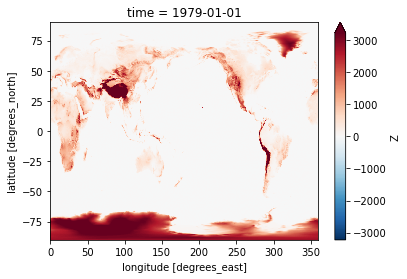

In [11]:
# raw data
g = 9.80665
ds = xr.open_dataset('./e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc')
elev = (ds.Z[0] / g)
elev.plot(robust=True)

# reformat 
elev = elev.drop('time').rename('elevation').to_dataset()
elev = elev.rename({'latitude': 'lat', 'longitude': 'lon'})
elev

In [12]:
# first bilinearly interpolate to a 0.25 degree grid 
output_degree = 0.25
output_path = make_coarse_elev_path(output_degree)
store = fsspec.get_mapper(output_path)

if '.zmetadata' not in store:
    elev_regridded = bilinear_interpolate(output_degree=output_degree, ds=elev)
    elev_regridded.to_zarr(store, mode="w", consolidated=True)
else:
    elev_regridded = xr.open_zarr(store)
    
# then interpolate the 0.25 grid into 0.5 and 1.0 with conservative method 
elev_regridded.load()
for output_degree in [0.5, 1.0]:
    output_path = make_coarse_elev_path(output_degree)
    store = fsspec.get_mapper(output_path)
    if '.zmetadata' not in store:
        ds_regridded = conservative_interpolate(output_degree=output_degree, ds=elev_regridded)
        ds_regridded.to_zarr(store, mode="w", consolidated=True)
    else:
        ds_regridded = xr.open_zarr(store)

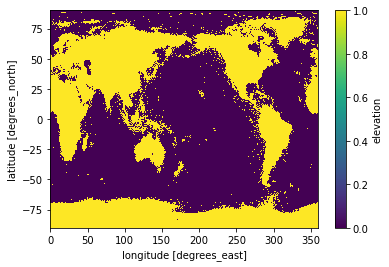

In [13]:
# inspect the elevation data to use as land mask 

# use abs elevation > 1 as land mask 
# only saving patches where > 50% is land 
np.abs(elev.elevation > 1).astype(int).plot(robust=True)

## Visualilze data together 

In [14]:
def get_data(path):
    store = fsspec.get_mapper(intermediate_cache_path + '/' + path)
    return xr.open_zarr(store)

for predicting 0.25 degree from 0.5 degree maps


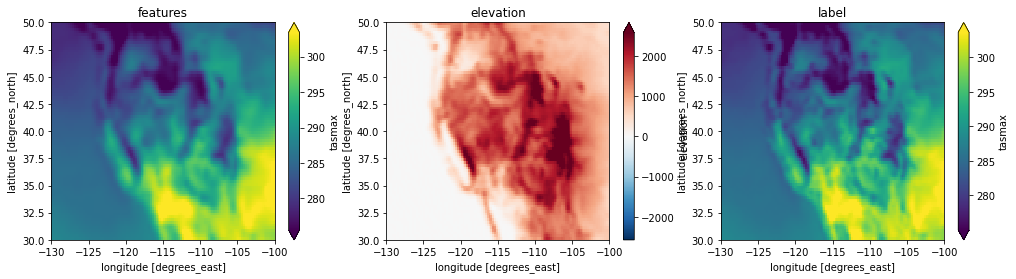

for predicting 0.5 degree from 1.0 degree maps


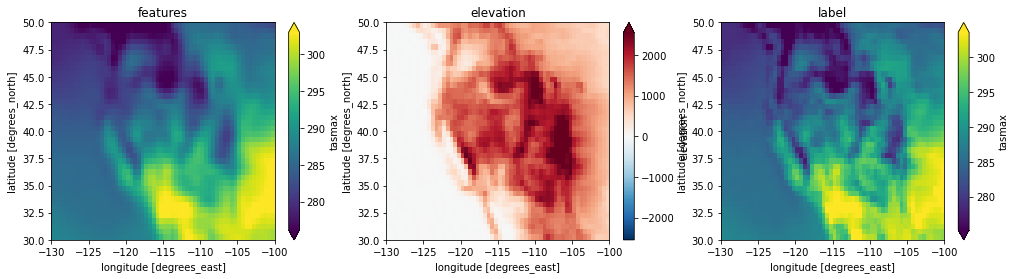

for predicting 1.0 degree from 2.0 degree maps


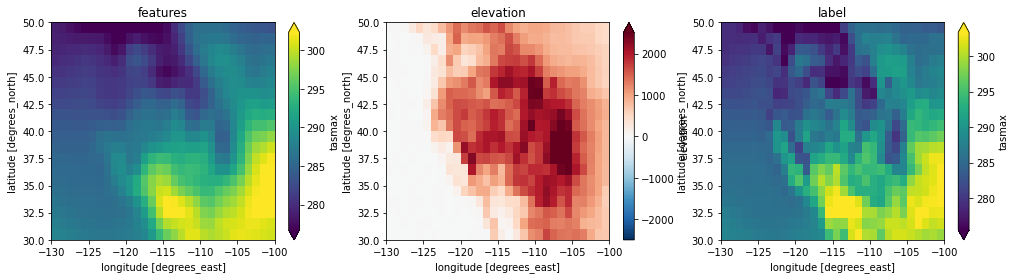

for predicting 0.25 degree from 0.5 degree maps


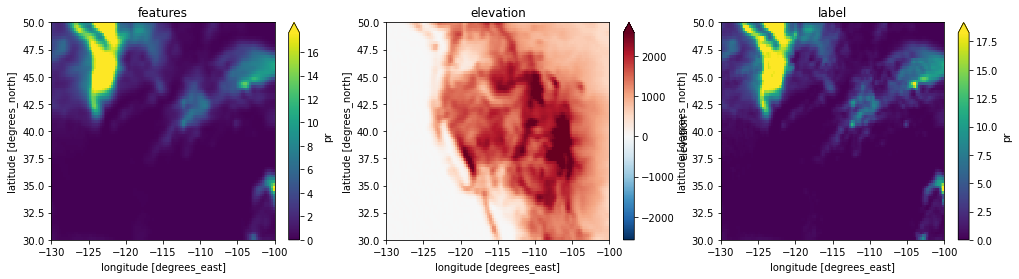

for predicting 0.5 degree from 1.0 degree maps


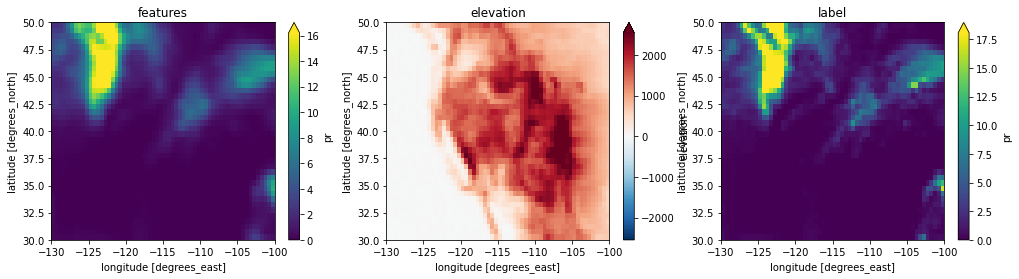

for predicting 1.0 degree from 2.0 degree maps


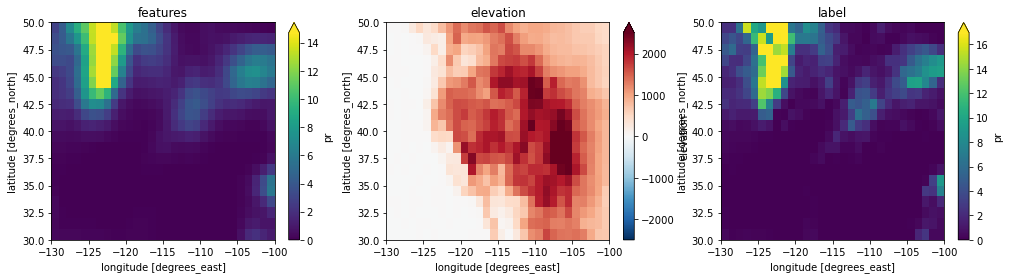

In [15]:
time = 100
lat = slice(30, 50)
lon = slice(-130, -100)

obs = run_hyperparameters["OBS"]
train_period_start = run_hyperparameters["TRAIN_PERIOD_START"]
train_period_end = run_hyperparameters["TRAIN_PERIOD_END"]
variables = run_hyperparameters["VARIABLES"]

for var in ['tasmax', 'pr']:
    for output_degree in [0.25, 0.5, 1.0]:
        print(f'for predicting {output_degree} degree from {output_degree*2} degree maps')
        gcm_grid_spec = build_grid_spec(output_degree=output_degree)
        label_path = make_coarse_obs_path(
            obs=obs,
            train_period_start=train_period_start,
            train_period_end=train_period_end,
            variables=variables,
            gcm_grid_spec=gcm_grid_spec,
            chunking_approach='full_space'
        )
        ds_obs_label = get_data(label_path)

        feature_path = make_interpolated_obs_path(
            obs=obs,
            train_period_start=train_period_start,
            train_period_end=train_period_end,
            variables=variables,
            gcm_grid_spec=gcm_grid_spec,
            chunking_approach='full_space'
        )
        ds_obs_feature = get_data(feature_path)
        
        ds_elev = get_elevation_data(output_degree)
        
        plt.figure(figsize=(17, 4))
        
        plt.subplot(1,3,1)
        ds_obs_feature[var].isel(time=time).sel(lat=lat, lon=lon).plot(robust=True, ax=plt.gca())
        plt.title('features')
        
        plt.subplot(1,3,2)
        ds_elev.elevation.sel(lat=lat, lon=lon).plot(robust=True, ax=plt.gca())
        plt.title('elevation')
        
        plt.subplot(1,3,3)
        ds_obs_label[var].isel(time=time).sel(lat=lat, lon=lon).plot(robust=True, ax=plt.gca())
        plt.title('label')
        plt.show()
        plt.close()

## Create patches for training

In the deepsd setup, the models are trained with "patches" of the data, instead of the entire map at the same time. This block of code generates these patches using xbatcher, and save the resulting data in tfrecord format for later usage. 

The patches used for training is 51 x 51 in the spatial dimensions (lat/lon or x/y), and contains 2 layers (1 for the coarsened/interpolated image, 1 for fine scale elevation). The labels are the same spatial patch from the fine scale image. This process is repeated for each level of model. 

The data in the patches are normalized (z-scored) using a historical period defined by train_period_start and train_period_end. At the time of writing this is set to 1981-2010. 

In [16]:
# the next three functions are copied from tensorflow documentation, only used when serializing the data from regular numpy to tfrecord 
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# the next two functions are wrappers used for converting patches to serialized tensorflow records 
def serialize_example(img_in, label, lat, lon, time):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    # hr = high resolution, lr = low resolution 
    # h = height, w = width, d = depth
    hr_h, hr_w, hr_d = img_in.shape
    lr_h, lr_w, lr_d = label.shape
    
    feature = {
        'hr_h': _int64_feature(hr_h),
        'hr_w': _int64_feature(hr_w),
        'hr_d': _int64_feature(hr_d),
        'lr_h': _int64_feature(lr_h),
        'lr_w': _int64_feature(lr_w),
        'lr_d': _int64_feature(lr_d),
        'label': _bytes_feature(tf.io.serialize_tensor(label)),
        'img_in': _bytes_feature(tf.io.serialize_tensor(img_in)),
        'lat': _bytes_feature(tf.io.serialize_tensor(lat)),
        'lon': _bytes_feature(tf.io.serialize_tensor(lon)),
        # TODO: this needs to be string 
        'time': _bytes_feature(str(time).encode('utf-8')),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def convert_to_tf(filename, inputs, labels, lats, lons, times, elevs):
    # change all datatype to float32
    inputs = inputs.astype(np.float32)
    labels = labels.astype(np.float32)
    lats = lats.astype(np.float32)
    lons = lons.astype(np.float32)
        
    with tf.io.TFRecordWriter(filename) as writer:
        total_in = inputs.shape[0]
        land = 0
        nans = 0
        # loop through each patch and serialize/write them 
        for i, img_in in enumerate(inputs):
            # only saving patches where > 30% is land 
            if np.mean(np.abs(elevs[i, :, :, :]) < 1) > 0.7:
                continue
            
            if not np.isfinite(img_in).all():
                nans += 1
                continue 
            example = serialize_example(img_in, labels[i], lats[i], lons[i], times[i][0])
            writer.write(example)
            land += 1
        print(f'{total_in} input patches, saving {land} that are mostly land, {nans} nans')

In [17]:
# note that the deepsd code on github shows an input size of 38 in the config file https://github.com/tjvandal/deepsd/blob/1978773b41141347aedc3c689e2297b024ef71bb/config-large.ini#L19
# however, the deepsd paper indicated that training is done with 51x51 patches at a stride of 20 https://arxiv.org/pdf/1703.03126.pdf
# in general, we go with the parameters set by the paper here 

from cmip6_downscaling.methods.deepsd import INPUT_SIZE, PATCH_STRIDE

sample_size = {'lat': INPUT_SIZE, 'lon': INPUT_SIZE, 'time': 1, 'variable': 8}
stride = PATCH_STRIDE 
input_overlap = {
    'lat': sample_size['lat'] - stride, 
    'lon': sample_size['lon'] - stride, 
}

In [18]:
import os
import fsspec

fs = fsspec.get_filesystem_class('az')(
    account_name='carbonplan', account_key=os.environ['TF_AZURE_STORAGE_KEY']
)

In [19]:
from cmip6_downscaling.methods.deepsd import EPSILON, get_obs_mean, get_obs_std, normalize

# for output_degree in [0.25, 0.5, 1.0]:
for output_degree in [0.25]:
    print(f'for predicting {output_degree} degree from {output_degree*2} degree maps')
    gcm_grid_spec = build_grid_spec(output_degree=output_degree)
    
    print('label')
    # loading label data 
    label_path = make_coarse_obs_path(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )
    ds_obs_label = get_data(label_path)
    
    # calculate mean and std for normalizing/zscoring
    ds_obs_label_mean = get_obs_mean(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_label
    )
    ds_obs_label_std = get_obs_std(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_label
    )
    ds_obs_label = ((ds_obs_label - ds_obs_label_mean) / (ds_obs_label_std + EPSILON))
    
    print('feature')
    # get feature data 
    feature_path = make_interpolated_obs_path(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )
    ds_obs_feature = get_data(feature_path)
    
    # calculate mean and std for normalizing/zscoring
    ds_obs_feature_mean = get_obs_mean(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_feature
    )
    ds_obs_feature_std = get_obs_std(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_feature
    )
    ds_obs_feature = ((ds_obs_feature - ds_obs_feature_mean) / (ds_obs_feature_std + EPSILON))

    print('elev')
    # load and normalize elevation data 
    ds_elev = get_elevation_data(output_degree)
    ds_elev_norm = normalize(ds=ds_elev, dims=['lat', 'lon'], epsilon=EPSILON)
    
    # chunk elevation data so that it's spatially contiguous 
    # and put all the features/label data into the same dataset, this is so that when using xbatcher to generate patches, all variables can be subsetted at the same time 
    ds_obs_feature['elevation'] = ds_elev_norm['elevation'].chunk({'lat': -1, 'lon': -1})
    for var in ['tasmax', 'tasmin', 'pr']:
        ds_obs_feature[var + '_label'] = ds_obs_label[var]
    # the un-normalized elevation is also passed into the patch generation code, but is only used to filter out water patches 
    ds_obs_feature['elevation_original'] = ds_elev['elevation'].chunk({'lat': -1, 'lon': -1})
    
    # convert into an array such that "variable" becomes a dimension 
    ds_obs_feature = ds_obs_feature.to_array(name='tf')
    
    # loop through each year/month and generate batches for each month 
    for year, ds_year in ds_obs_feature.groupby('time.year'):
        if year >= 2009:
            for month, ds_month in ds_year.groupby('time.month'):
                print(f'processing {year}-{month:02d}')

                bgen = xbatcher.BatchGenerator(
                    ds=ds_month,
                    input_dims=sample_size,  
                    concat_input_dims=True,
                    input_overlap=input_overlap,
                    preload_batch=True
                )
                # even though there's a for loop here, there's really only one batch in the generator
                # we are only uing xbatcher to create the patches and not using the batching capability 
                for j, batch in enumerate(bgen):
                    batch = batch.transpose('input_batch', 'lat_input', 'lon_input', 'variable_input', 'time_input').load()
                    for var in ['pr', 'tasmax', 'tasmin']:
                    # for var in ['tasmax']:
                        print('variable', var)
                        # grab the correct inputs for each variable and get the numpy versions of data 
                        input_vars = [np.argwhere(batch.variable.values == var)[0][0]] + [np.argwhere(batch.variable.values == 'elevation')[0][0]]
                        label_var = [np.argwhere(batch.variable.values == var + '_label')[0][0]]
                        elev_var = [np.argwhere(batch.variable.values == 'elevation_original')[0][0]]

                        inputs = batch.isel(variable_input=input_vars).squeeze('time_input').tf.values
                        labels = batch.isel(variable_input=label_var).squeeze('time_input').tf.values
                        elevs = batch.isel(variable_input=elev_var).squeeze('time_input').tf.values
                        lats = batch.lat.values
                        lons = batch.lon.values
                        times = batch.time.values

                        d = str(output_degree).replace('.', '_')
                        filename = f'az://cmip6downscaling/training/deepsd/{var}/{d}/{year}-{month:02d}-zscore.tfrecords'

                        fn_wo_container = f'az://training/deepsd/{var}/{d}/{year}-{month:02d}-zscore.tfrecords'
                        # if fs.exists(fn_wo_container):
                        #     print(f'{filename} already exists, skipping')
                        # else:
                        print(f'{filename} processing')
                        convert_to_tf(filename, inputs, labels, lats, lons, times, elevs) 

                    del batch, inputs, labels, lats, lons, times, ds_month


for predicting 0.25 degree from 0.5 degree maps
label
feature
elev
processing 2009-01
variable pr
az://cmip6downscaling/training/deepsd/pr/0_25/2009-01-zscore.tfrecords processing


2022-02-01 09:05:25.172455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-01 09:05:25.172505: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 09:05:25.172550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-tcchiao): /proc/driver/nvidia/version does not exist
2022-02-01 09:05:25.172921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


73780 input patches, saving 35898 that are mostly land, 0 nans
variable tasmax
az://cmip6downscaling/training/deepsd/tasmax/0_25/2009-01-zscore.tfrecords processing
73780 input patches, saving 35898 that are mostly land, 0 nans
variable tasmin
az://cmip6downscaling/training/deepsd/tasmin/0_25/2009-01-zscore.tfrecords processing
73780 input patches, saving 35898 that are mostly land, 0 nans
processing 2009-02
variable pr
az://cmip6downscaling/training/deepsd/pr/0_25/2009-02-zscore.tfrecords processing
66640 input patches, saving 32424 that are mostly land, 0 nans
variable tasmax
az://cmip6downscaling/training/deepsd/tasmax/0_25/2009-02-zscore.tfrecords processing
66640 input patches, saving 32424 that are mostly land, 0 nans
variable tasmin
az://cmip6downscaling/training/deepsd/tasmin/0_25/2009-02-zscore.tfrecords processing
66640 input patches, saving 32424 that are mostly land, 0 nans
processing 2009-03
variable pr
az://cmip6downscaling/training/deepsd/pr/0_25/2009-03-zscore.tfrecords

In [20]:
import random
# for plotting with lat/lon potentially use the following 
# batch.isel(input_batch=1).tf..plot.pcolormesh(strings)
for _ in range(10):

    i = random.randint(0, len(batch.input_batch))
    patch = batch.isel(input_batch=i)
    print(patch.lat.min().values, patch.lat.max().values)
    print(patch.lon.min().values, patch.lon.max().values)
    test_vals = patch.tf.values

    plt.figure(figsize=(17, 4))

    plt.subplot(1,3,1)
    plt.imshow(test_vals[:, :, 0], vmin=0, vmax=20)
    plt.title('features')

    plt.subplot(1,3,2)
    plt.imshow(test_vals[:, :, 1], vmin=0, vmax=1500)
    plt.title('elevation')

    plt.subplot(1,3,3)
    plt.imshow(test_vals[:, :, 2], vmin=0, vmax=20)
    plt.title('label')
    plt.show()
    plt.close()

NameError: name 'batch' is not defined

In [20]:
from cmip6_downscaling.methods.deepsd import EPSILON, get_obs_mean, get_obs_std, normalize


In [57]:
for output_degree in [1.0]:
    print(f'for predicting {output_degree} degree from {output_degree*2} degree maps')
    gcm_grid_spec = build_grid_spec(output_degree=output_degree)
    
    print('label')
    # loading label data 
    label_path = make_coarse_obs_path(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )
    ds_obs_label = get_data(label_path)
    
    # calculate mean and std for normalizing/zscoring
    ds_obs_label_mean = get_obs_mean(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_label
    )
    ds_obs_label_std = get_obs_std(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_label
    )
    ds_obs_label = ((ds_obs_label - ds_obs_label_mean) / (ds_obs_label_std + EPSILON))
    
    print('feature')
    # get feature data 
    feature_path = make_interpolated_obs_path(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        chunking_approach='full_space'
    )
    ds_obs_feature = get_data(feature_path)
    
    # calculate mean and std for normalizing/zscoring
    ds_obs_feature_mean = get_obs_mean(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_feature
    )
    ds_obs_feature_std = get_obs_std(
        obs=obs,
        train_period_start=train_period_start,
        train_period_end=train_period_end,
        variables=variables,
        gcm_grid_spec=gcm_grid_spec,
        ds=ds_obs_feature
    )
    ds_obs_feature = ((ds_obs_feature - ds_obs_feature_mean) / (ds_obs_feature_std + EPSILON))

    print('elev')
    # load and normalize elevation data 
    ds_elev = get_elevation_data(output_degree)
    ds_elev_norm = normalize(ds=elev, dims=['lat', 'lon'], epsilon=EPSILON)

for predicting 1.0 degree from 2.0 degree maps
label
feature
elev


In [62]:
print(np.isfinite(ds_obs_feature.pr).all().values)
print(np.isfinite(ds_obs_feature.tasmax).all().values)
print(np.isfinite(ds_obs_feature.tasmin).all().values)

True
True
True


In [63]:
ds_obs_feature['elevation'] = ds_elev_norm['elevation'].chunk({'lat': -1, 'lon': -1})

In [71]:
ds_elev

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    elevation  (lat, lon) float32 dask.array<chunksize=(90, 360), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

In [70]:
ds_elev_norm

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440)
Coordinates:
  * lat        (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    elevation  (lat, lon) float64 -0.4458 -0.4458 -0.4458 ... 2.829 2.829 2.829

In [64]:
print(np.isfinite(ds_obs_feature.pr).all().values)
print(np.isfinite(ds_obs_feature.tasmax).all().values)
print(np.isfinite(ds_obs_feature.tasmin).all().values)
print(np.isfinite(ds_obs_feature.elevation).all().values)

True
True
True
False


In [65]:
for var in ['tasmax', 'tasmin', 'pr']:
    ds_obs_feature[var + '_label'] = ds_obs_label[var]

In [66]:
print(np.isfinite(ds_obs_feature.pr_label).all().values)
print(np.isfinite(ds_obs_feature.tasmax_label).all().values)
print(np.isfinite(ds_obs_feature.tasmin_label).all().values)
print(np.isfinite(ds_obs_feature.elevation).all().values)
print(np.isfinite(ds_obs_feature.pr).all().values)
print(np.isfinite(ds_obs_feature.tasmax).all().values)
print(np.isfinite(ds_obs_feature.tasmin).all().values)

True
True
True
False
True
True
True


In [67]:
ds_obs_feature['elevation_original'] = ds_elev['elevation'].chunk({'lat': -1, 'lon': -1})

In [68]:
print(np.isfinite(ds_obs_feature.pr_label).all().values)
print(np.isfinite(ds_obs_feature.tasmax_label).all().values)
print(np.isfinite(ds_obs_feature.tasmin_label).all().values)
print(np.isfinite(ds_obs_feature.elevation).all().values)
print(np.isfinite(ds_obs_feature.pr).all().values)
print(np.isfinite(ds_obs_feature.tasmax).all().values)
print(np.isfinite(ds_obs_feature.tasmin).all().values)
print(np.isfinite(ds_obs_feature.elevation_original).all().values)

True
True
True
False
True
True
True
True


In [53]:
# convert into an array such that "variable" becomes a dimension 
ds_obs_feature = ds_obs_feature.to_array(name='tf')

In [55]:
np.isfinite(ds_obs_feature).all().values

array(False)

In [56]:
for year, ds_year in ds_obs_feature.groupby('time.year'):
    for month, ds_month in ds_year.groupby('time.month'):
        print(f'processing {year}-{month:02d}')

        bgen = xbatcher.BatchGenerator(
            ds=ds_month,
            input_dims=sample_size,  
            concat_input_dims=True,
            input_overlap=input_overlap,
            preload_batch=True
        )
        # even though there's a for loop here, there's really only one batch in the generator
        # we are only uing xbatcher to create the patches and not using the batching capability 
        for j, batch in enumerate(bgen):
            break
            
        break 
    break 

processing 1981-01


In [ ]:
batch = batch.transpose('input_batch', 'lat_input', 'lon_input', 'variable_input', 'time_input').load()
            for var in ['pr', 'tasmax', 'tasmin']:
            # for var in ['tasmax']:
                print('variable', var)
                # grab the correct inputs for each variable and get the numpy versions of data 
                input_vars = [np.argwhere(batch.variable.values == var)[0][0]] + [np.argwhere(batch.variable.values == 'elevation')[0][0]]
                label_var = [np.argwhere(batch.variable.values == var + '_label')[0][0]]
                elev_var = [np.argwhere(batch.variable.values == 'elevation_original')[0][0]]

                inputs = batch.isel(variable_input=input_vars).squeeze('time_input').tf.values
                labels = batch.isel(variable_input=label_var).squeeze('time_input').tf.values
                elevs = batch.isel(variable_input=elev_var).squeeze('time_input').tf.values
                lats = batch.lat.values
                lons = batch.lon.values
                times = batch.time.values